# Importing Necessary Packages

In [6]:
#packages for data data manipulation
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
# Importing Models
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import SGDRegressor
from keras.models import Sequential
from keras.layers import Dense, LSTM,Bidirectional
# Importing evaluation modules
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_val_score
#data scalling
from sklearn.preprocessing import MinMaxScaler
minmax_scaler=MinMaxScaler()

# Reading the Data

In [7]:
df = pd.read_excel('(미디어에버) BioParticle Counter 6개월 측정 20230314.xlsx',
                   sheet_name='data',
                  header=1)

In [8]:
df.head()

,Unnamed: 0,Day,Time,Bio,Dust,T,H,PM2.5
0,NaN,NaT,NaN,#/L,#/L,NaN,NaN,NaN
1,NaN,2022-05-01,00:03:29,11,34254,25.5,27.0,30.984
2,NaN,2022-05-01,00:07:36,19,33980,25.5,27.0,30.750
3,NaN,2022-05-01,00:11:43,28,33378,25.5,27.0,30.235
4,NaN,2022-05-01,00:15:50,47,33092,25.5,27.0,29.990


In [9]:
#setting path to store images
import os
dir=os.listdir()
if "bio" in dir:
    pass
else:
    # Specify the directory path
    directory_path = "./bio"
    # Use the os.makedirs() function to create the directory
    os.makedirs(directory_path)

# Data Preparation

### Dropping Un-necessary Columns

In [10]:
df.drop(['Unnamed: 0'],axis=1,inplace=True)
df.dropna(axis=0,inplace=True)

In [11]:
#converting data type of Dust and Bio to int
df['Dust']=df['Dust'].astype(int)
df['Bio']=df['Bio'].astype(int)

In [12]:
#joining Day and Time in form of string
df['Date_Time']=df['Day'].astype(str)+' '+df['Time'].astype(str)
df['Date_Time'] = pd.to_datetime(df['Date_Time'])

In [13]:
df['Date_Time'] =df['Date_Time'].values.astype(np.int64)
df.drop(['Day','Time'],axis=1,inplace=True)

# Data Visualization

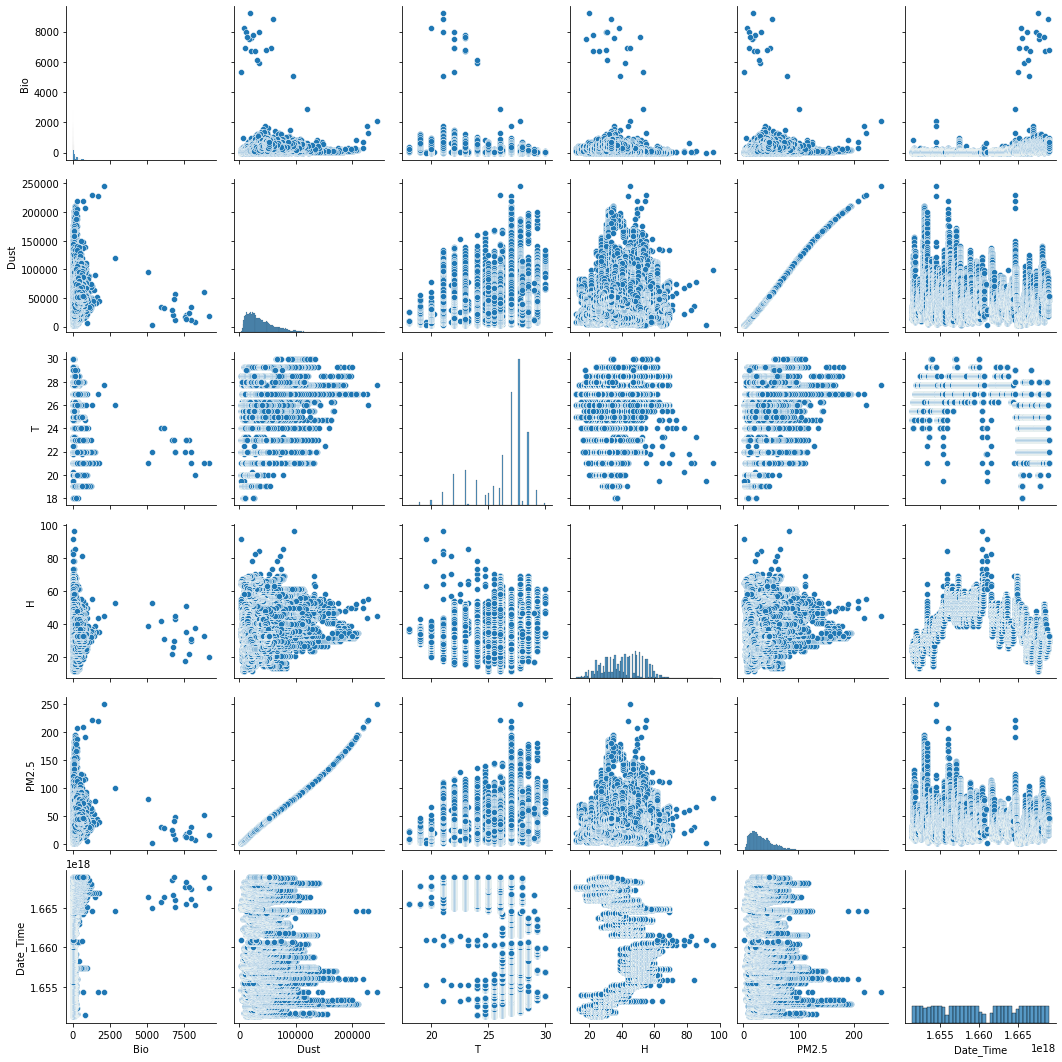

In [14]:
sns.pairplot(df)

# Features Correlation

In [15]:
### applying log Transformation on features

In [16]:
df['h_log']=np.log(df['H'])
df['pm2.5_log']=np.log(df['PM2.5'])
df[df['Bio']==0]=1
df['bio_log']=np.log(df['Bio'])

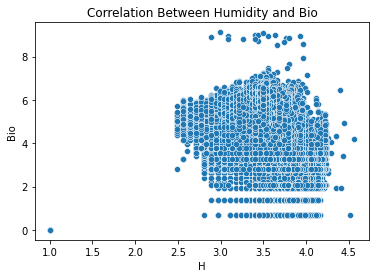

Pearson Correlation : 0.0575416205989908


In [17]:
sns.scatterplot(x=df['h_log'],y=df['bio_log'])
plt.xlabel('H')
plt.ylabel('Bio')
plt.title('Correlation Between Humidity and Bio')
plt.savefig('./bio/Correlation Between Humidity and Bio.jpeg')
plt.show()
print('Pearson Correlation :',np.corrcoef(df['h_log'],df['bio_log'])[0][1])

In [18]:
df['t_log']=np.log(df['T'])

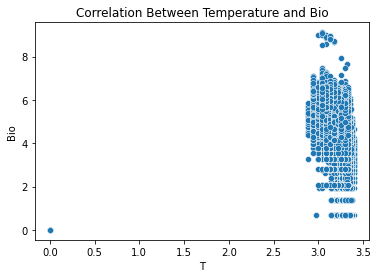

Pearson Correlation : 0.2356883223559614


In [19]:
sns.scatterplot(x=df['t_log'],y=df['bio_log'])
plt.xlabel('T')
plt.ylabel('Bio')
plt.title('Correlation Between Temperature and Bio')
plt.savefig('./bio/Correlation Between Temperature and Bio.jpeg')
plt.show()
print('Pearson Correlation :',np.corrcoef(df['t_log'],df['bio_log'])[0][1])

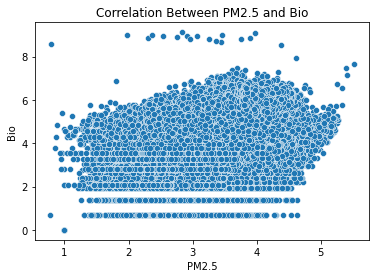

Pearson Correlation : 0.38420325771144853


In [20]:
sns.scatterplot(x=df['pm2.5_log'],y=df['bio_log'])
plt.xlabel('PM2.5')
plt.ylabel('Bio')
plt.title('Correlation Between PM2.5 and Bio')
plt.savefig('./bio/Correlation Between PM2.5 and Bio.jpeg')
plt.show()
print('Pearson Correlation :',np.corrcoef(df['pm2.5_log'],df['bio_log'])[0][1])

In [21]:
df['dust_log']=np.log(df['Dust'])

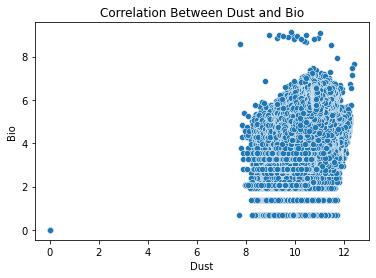

Pearson Correlation : 0.44273919969888026


In [22]:
sns.scatterplot(x=df['dust_log'],y=df['bio_log'])
plt.xlabel('Dust')
plt.ylabel('Bio')
plt.title('Correlation Between Dust and Bio')
plt.savefig('./bio/Correlation Between Dust and Bio.jpeg')
plt.show()
print('Pearson Correlation :',np.corrcoef(df['dust_log'],df['bio_log'])[0][1])

In [23]:
df['date_time_log']=np.log(df['Date_Time'])

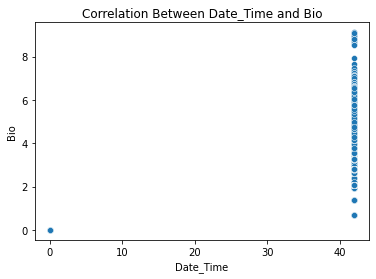

Pearson Correlation : 0.36517168953305623


In [24]:
sns.scatterplot(x=df['date_time_log'],y=df['bio_log'])
plt.xlabel('Date_Time')
plt.ylabel('Bio')
plt.title('Correlation Between Date_Time and Bio')
plt.savefig('./bio/Correlation Between Date_Time and Bio.jpeg')
plt.show()
print('Pearson Correlation :',np.corrcoef(df['date_time_log'],df['bio_log'])[0][1])

In [25]:
X=df.drop(['Bio','H','T','Dust','Date_Time','PM2.5'],axis=1)
y=df['Bio']

In [26]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)

# Willmote Index

In [27]:
def willmott_index(observed, predicted):
    mean_observed = np.mean(observed)
    numerator = np.sum(np.abs(observed - predicted))
    denominator = np.sum(np.abs(observed - mean_observed))
    wi = (1 - (numerator / denominator))
    return wi

In [28]:
train_l = []
test_l = []
mae_l = []
rmse_l = []
r2_l = []
wi_l = []
cv_scores=[]

In [29]:
models_names=['Ridge','LR','KNN Regressor','RF Regressor','DT Regressor','SGD Regressor']
              #,'SV Regressor']

In [30]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet

# Create an instance of Elastic Net regression
elastic_net = ElasticNet(alpha=0.1, l1_ratio=0.5)

from sklearn.ensemble import AdaBoostRegressor
adaboost = AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=0.1)

import xgboost as xgb

# Create an instance of XGBoost regressor
xgboost = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)


+ ==================================================================================================== +
			1-For Ridge The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  144.15872578169527
--------------------------------------------------
Mean absolute error (MAE) :  52.81139040274082
--------------------------------------------------
R2 score :  0.43144527053521053
--------------------------------------------------
CV Score :  [-1.04463625 -2.10695913 -4.88078147  0.13864679 -0.07612512]
--------------------------------------------------
Willmott's Index: 0.4566611033596003
--------------------------------------------------


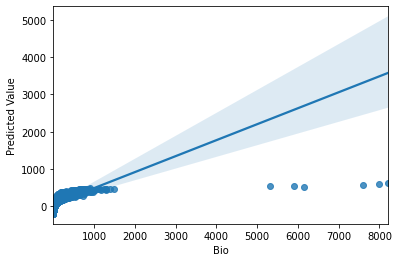

							-----------------------------------------------------------
							 Time for detection (Ridge) : 3.434 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			2-For LinearRegression The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  144.17364027876522
--------------------------------------------------
Mean absolute error (MAE) :  52.806771521062494
--------------------------------------------------
R2 score :  0.4313276204040629
--------------------------------------------------
CV Score :  [-1.04892969 -2.10285423 -4.85889592  0.13708263 -0.07490055]
--------------------------------------------------
Willmott's Index: 0.4567086237535092
--------------------------------------------------


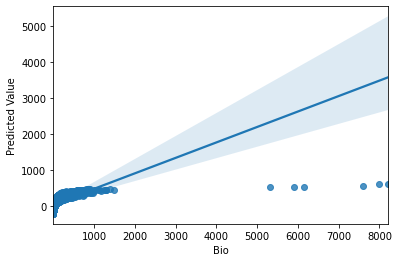

							-----------------------------------------------------------
							 Time for detection (LinearRegression) : 3.643 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			3-For KNeighborsRegressor The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  15.290920200833964
--------------------------------------------------
Mean absolute error (MAE) :  1.766526302557979
--------------------------------------------------
R2 score :  0.9936032754434531
--------------------------------------------------
CV Score :  [0.957627   0.99219239 0.99862025 0.98615588 0.89613788]
--------------------------------------------------
Willmott's Index: 0.9818254652112268
--------------------------------------------------


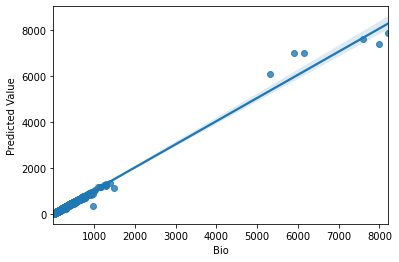

							-----------------------------------------------------------
							 Time for detection (KNeighborsRegressor) : 12.356 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			4-For Random Forest The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  14.214033550354346
--------------------------------------------------
Mean absolute error (MAE) :  0.24517377914650237
--------------------------------------------------
R2 score :  0.9944725467375874
--------------------------------------------------
CV Score :  [0.99782273 0.99998782 0.99999718 0.99366866 0.98982377]
--------------------------------------------------
Willmott's Index: 0.9974775810742581
--------------------------------------------------


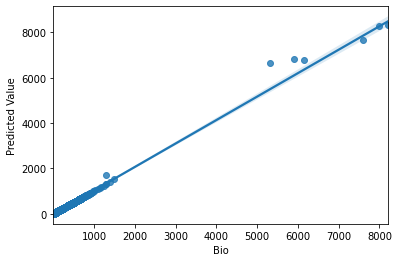

							-----------------------------------------------------------
							 Time for detection (Random Forest) : 124.49 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			5-For Decision Tree The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  16.146964648181786
--------------------------------------------------
Mean absolute error (MAE) :  0.27107032870341274
--------------------------------------------------
R2 score :  0.9928670004675894
--------------------------------------------------
CV Score :  [0.99501307 0.99998319 0.99999477 0.99554266 0.99199126]
--------------------------------------------------
Willmott's Index: 0.9972111498639502
--------------------------------------------------


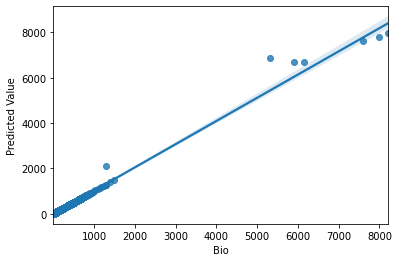

							-----------------------------------------------------------
							 Time for detection (Decision Tree) : 4.328 seconds...
							-----------------------------------------------------------



c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before convergence. Consider increasing max_iter to improve the fit.
  warnings.warn(
c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_stochastic_gradient.py:1527: ConvergenceWarning: Maximum number of iteration reached before converg

+ ==================================================================================================== +
			6-For SGD Regressor The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  181987.01842834306
--------------------------------------------------
Mean absolute error (MAE) :  123364.0474165279
--------------------------------------------------
R2 score :  -906088.7682863564
--------------------------------------------------
CV Score :  [-2.47134454e+10 -1.18237330e+09 -3.09681619e+09 -3.78219030e+07
 -9.07862765e+05]
--------------------------------------------------
Willmott's Index: -1268.2050880923514
--------------------------------------------------


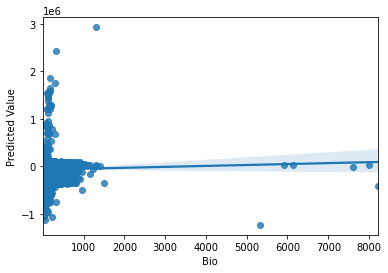

							-----------------------------------------------------------
							 Time for detection (SGD Regressor) : 101.708 seconds...
							-----------------------------------------------------------



c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.063e+08, tolerance: 1.609e+05
  model = cd_fast.enet_coordinate_descent(
c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.550e+08, tolerance: 2.114e+05
  model = cd_fast.enet_coordinate_descent(
c:\users\zee tech\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check t

+ ==================================================================================================== +
			7-For Lasso Regression The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  144.17445236229236
--------------------------------------------------
Mean absolute error (MAE) :  52.830231200676
--------------------------------------------------
R2 score :  0.43132121409051594
--------------------------------------------------
CV Score :  [-1.04887019 -2.11648462 -4.92862037  0.13772635 -0.07875488]
--------------------------------------------------
Willmott's Index: 0.45646726376772706
--------------------------------------------------


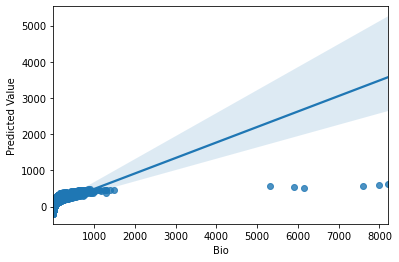

							-----------------------------------------------------------
							 Time for detection (Lasso Regression) : 12.309 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			8-For ElasticNet Regressor The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  145.4681320937573
--------------------------------------------------
Mean absolute error (MAE) :  56.996870628484345
--------------------------------------------------
R2 score :  0.4210698987127983
--------------------------------------------------
CV Score :  [-1.43400553 -2.79862133 -6.0279626   0.18312758 -0.13632799]
--------------------------------------------------
Willmott's Index: 0.4135996692556485
--------------------------------------------------


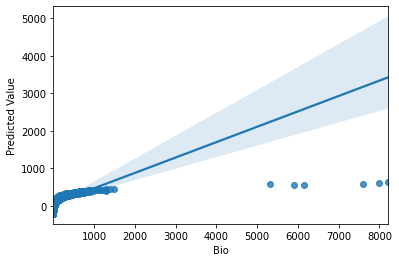

							-----------------------------------------------------------
							 Time for detection (ElasticNet Regressor) : 10.386 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			9-For Adaboost Regressor The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  15.108692157798608
--------------------------------------------------
Mean absolute error (MAE) :  0.21513418389793224
--------------------------------------------------
R2 score :  0.9937548316281257
--------------------------------------------------
CV Score :  [0.9950149  0.99998906 0.99999672 0.99381722 0.97780704]
--------------------------------------------------
Willmott's Index: 0.9977866371398798
--------------------------------------------------


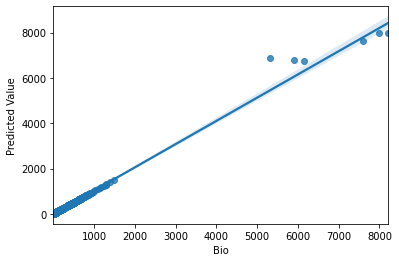

							-----------------------------------------------------------
							 Time for detection (Adaboost Regressor) : 140.648 seconds...
							-----------------------------------------------------------

+ ==================================================================================================== +
			10-For XGboost Regressor The Performance result is: 
+ ==================================================================================================== +
Root mean squared error (RMSE) :  12.372705804584044
--------------------------------------------------
Mean absolute error (MAE) :  0.19509001239271692
--------------------------------------------------
R2 score :  0.995811873607742
--------------------------------------------------
CV Score :  [0.99540367 0.99998514 0.99999697 0.99664332 0.99114119]
--------------------------------------------------
Willmott's Index: 0.9979928573879486
--------------------------------------------------


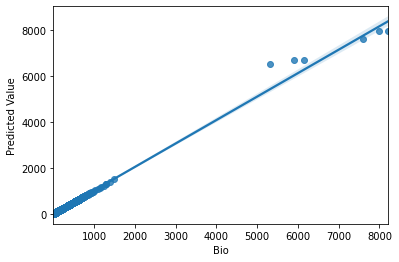

							-----------------------------------------------------------
							 Time for detection (XGboost Regressor) : 22.214 seconds...
							-----------------------------------------------------------



In [31]:


# Create an instance of Lasso regression
lasso = Lasso(alpha=0.1)
# check the performance on diffrent regressor
models = []
models.append(('Ridge', Ridge()))
models.append(('LinearRegression', LinearRegression()))
models.append(('KNeighborsRegressor', KNeighborsRegressor()))
models.append(('Random Forest', RandomForestRegressor()))
models.append(('Decision Tree', DecisionTreeRegressor()))
models.append(('SGD Regressor', SGDRegressor()))
#models.append(('SV Regressor', SVR()))
models.append(('Lasso Regression',  Lasso(alpha=0.01)))
models.append(('ElasticNet Regressor',  ElasticNet(alpha=0.01, l1_ratio=0.05)))
models.append(('Adaboost Regressor', AdaBoostRegressor(base_estimator=DecisionTreeRegressor(), n_estimators=100, learning_rate=0.1)))
models.append(('XGboost Regressor', xgb.XGBRegressor(n_estimators=100, learning_rate=0.1)))


train_l = []
test_l = []
mae_l = []
rmse_l = []
r2_l = []
wi_l = []
cv_scores=[]

import time
i = 0
for name,model in models:
    i = i+1
    start_time = time.time()
    
    # Fitting model to the Training set
    clf = model
    clf.fit(X_train, y_train)
    
    # Scores of model
    train = model.score(X_train, y_train)
    test = model.score(X_test, y_test)
    
    train_l.append(round(train,4))
    test_l.append(round(test,4))
    
    # predict values
    predictions = clf.predict(X_test)
    # RMSE
    rmse = np.sqrt(mean_squared_error(y_test, predictions))
    rmse_l.append(round(rmse,4))
    # MAE
    mae = mean_absolute_error(y_test,predictions)
    mae_l.append(round(mae,4))
    # R2 score
    r2 = r2_score(y_test,predictions)
    r2_l.append(round(r2,4))
    scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    cv_scores.append(round(np.mean(scores),4))


    print("+","="*100,"+")
    print('\033[1m' + f"\t\t\t{i}-For {name} The Performance result is: " + '\033[0m')
    print("+","="*100,"+")
    print('Root mean squared error (RMSE) : ', rmse)   
    print("-"*50)
    print('Mean absolute error (MAE) : ', mae)
    print("-"*50)
    print('R2 score : ', r2)
    print("-"*50)
    print('CV Score : ', scores)
    print("-"*50)
    
    wi = willmott_index(y_test, predictions)
    print(f"Willmott's Index: {wi}")
    wi_l.append(round(wi,4))
    print("-"*50)
    #wi = willmott_index(y_test, predictions)
    
    
    sns.regplot(x=y_test,y=predictions)
    plt.ylabel("Predicted Value")
    plt.savefig(f'./bio/{name} regplot.jpeg')
    plt.show()
        
        
    print("\t\t\t\t\t\t\t-----------------------------------------------------------")
    print(f"\t\t\t\t\t\t\t Time for detection ({name}) : {round((time.time() - start_time), 3)} seconds...")
    print("\t\t\t\t\t\t\t-----------------------------------------------------------")
    print()
    


In [32]:
report = pd.DataFrame({"Training Score": train_l,
                     "Testing Score": test_l, "MAE": mae_l,
                     "RMSE": rmse_l,
                     "R2 Score": r2_l,
                    "Willmot Index": wi_l})
report

,Training Score,Testing Score,MAE,RMSE,R2 Score,Willmot Index
0,0.4713,0.4314,52.8114,144.1587,0.4314,0.4567
1,0.4714,0.4313,52.8068,144.1736,0.4313,0.4567
2,0.9933,0.9936,1.7665,15.2909,0.9936,0.9818
3,0.9994,0.9945,0.2452,14.2140,0.9945,0.9975
4,1.0000,0.9929,0.2711,16.1470,0.9929,0.9972
5,-966772.9383,-906088.7683,123364.0474,181987.0184,-906088.7683,-1268.2051
6,0.4708,0.4313,52.8302,144.1745,0.4313,0.4565
7,0.4593,0.4211,56.9969,145.4681,0.4211,0.4136
8,1.0000,0.9938,0.2151,15.1087,0.9938,0.9978
9,1.0000,0.9958,0.1951,12.3727,0.9958,0.9980


In [33]:
# Define evaluation metrics
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2

In [34]:
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Assuming you have your data in X (features) and y (target variable)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create the ANN model
model = Sequential()
model.add(Dense(128, activation='relu', input_dim=X_train.shape[1]))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=200, batch_size=512)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model using mean squared error
mse = mean_squared_error(y_test, y_pred)
#print("Mean Squared Error:", mse)

y_val_pred=model.predict(X_test)
mse, rmse, mae, r2 = evaluate_regression(y_test, y_val_pred)
print("Evaluation Metrics ANN:")
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R^2:", round(r2,5))
wi=willmott_index(y_test, np.reshape(y_val_pred,y_val_pred.shape[0]))
print("Willmote Index:", round(wi,5))

Epoch 1/200
100/100 [==============================] - 1s 3ms/step - loss: 34859.1562
Epoch 2/200
100/100 [==============================] - 0s 3ms/step - loss: 31920.9512
Epoch 3/200
100/100 [==============================] - 0s 3ms/step - loss: 30174.8555
Epoch 4/200
100/100 [==============================] - 0s 3ms/step - loss: 24720.4316
Epoch 5/200
100/100 [==============================] - 0s 3ms/step - loss: 17614.3438
Epoch 6/200
100/100 [==============================] - 0s 3ms/step - loss: 14004.3096
Epoch 7/200
100/100 [==============================] - 0s 3ms/step - loss: 12327.2812
Epoch 8/200
100/100 [==============================] - 0s 3ms/step - loss: 11288.1631
Epoch 9/200
100/100 [==============================] - 0s 3ms/step - loss: 10532.4727
Epoch 10/200
100/100 [==============================] - 0s 3ms/step - loss: 10027.6445
Epoch 11/200
100/100 [==============================] - 0s 3ms/step - loss: 9494.0742
Epoch 12/200
100/100 [==============================]

100/100 [==============================] - 0s 2ms/step - loss: 160.9129
Epoch 97/200
100/100 [==============================] - 0s 2ms/step - loss: 127.0827
Epoch 98/200
100/100 [==============================] - 0s 2ms/step - loss: 157.2063
Epoch 99/200
100/100 [==============================] - 0s 2ms/step - loss: 137.2231
Epoch 100/200
100/100 [==============================] - 0s 2ms/step - loss: 130.6389
Epoch 101/200
100/100 [==============================] - 0s 2ms/step - loss: 155.2883
Epoch 102/200
100/100 [==============================] - 0s 2ms/step - loss: 161.4479
Epoch 103/200
100/100 [==============================] - 0s 2ms/step - loss: 147.8344
Epoch 104/200
100/100 [==============================] - 0s 2ms/step - loss: 159.9647
Epoch 105/200
100/100 [==============================] - 0s 2ms/step - loss: 140.7174
Epoch 106/200
100/100 [==============================] - 0s 3ms/step - loss: 98.9796
Epoch 107/200
100/100 [==============================] - 0s 3ms/step - l

100/100 [==============================] - 0s 2ms/step - loss: 34.4567
Epoch 192/200
100/100 [==============================] - 0s 2ms/step - loss: 53.4007
Epoch 193/200
100/100 [==============================] - 0s 2ms/step - loss: 88.1211
Epoch 194/200
100/100 [==============================] - 0s 2ms/step - loss: 110.1254
Epoch 195/200
100/100 [==============================] - 0s 2ms/step - loss: 71.0034
Epoch 196/200
100/100 [==============================] - 0s 2ms/step - loss: 82.0712
Epoch 197/200
100/100 [==============================] - 0s 2ms/step - loss: 91.1704
Epoch 198/200
100/100 [==============================] - 0s 2ms/step - loss: 72.0274
Epoch 199/200
100/100 [==============================] - 0s 2ms/step - loss: 48.4976
Epoch 200/200
100/100 [==============================] - 0s 2ms/step - loss: 137.0993
Evaluation Metrics ANN:
Test MSE: 141.67403238214058
Test RMSE: 11.902690132156705
Test MAE: 3.0309173821301374
Test R^2: 0.99644
Willmote Index: 0.96991


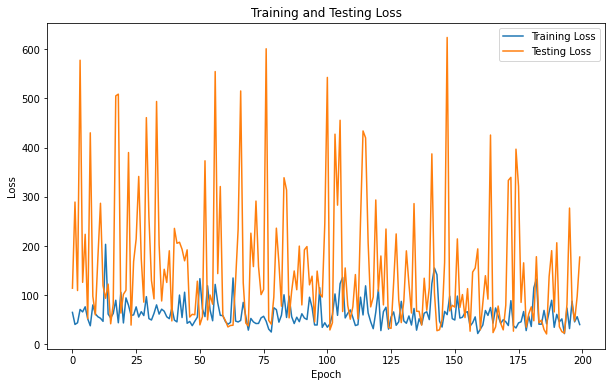

In [35]:
history=model.fit(X_train, y_train, epochs=200, batch_size=512, verbose=0,
                  validation_data=(X_test, y_test))
# Extract training and testing losses from history
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Plot training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.savefig('./bio/training and testing loss.jpeg')
plt.show()

In [64]:
# Reshape the input data to match LSTM layer input shape
train_data = np.resize(X_train, (X_train.shape[0], X_train.shape[1], 1))
test_data = np.resize(X_test, (X_test.shape[0], X_test.shape[1], 1))
train_labels=y_train
test_labels=y_test

In [ ]:
# Define LSTM model
def create_lstm_model():
    model = Sequential()
    model.add(LSTM(128, input_shape=(train_data.shape[1], train_data.shape[2]),return_sequences=True))  # LSTM layer with 64 units
    model.add(LSTM(64,return_sequences=True))
    model.add(LSTM(32,return_sequences=True))
    model.add(LSTM(16,return_sequences=True))
    model.add(LSTM(8,return_sequences=True))
    model.add(Dense(1))
    return model



# Define evaluation metrics
def evaluate_regression(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    return mse, rmse, mae, r2
    
# Create and compile LSTM model
model = create_lstm_model()
model.compile(optimizer='adam', loss='mean_squared_error')

# Train LSTM model
history=model.fit(train_data, train_labels, epochs=100, batch_size=512,
                  validation_data=(test_data, test_labels))
#cv_scores = cross_val_score(model, train_data, train_labels, cv=5, scoring=scoring)

# Extract training and testing losses from history
train_loss = history.history['loss']
test_loss = history.history['val_loss']

# Plot training and testing losses
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(test_loss, label='Testing Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Evaluate LSTM model on validation data
y_val_pred = model.predict(test_data)
#print(y_val_pred.shape)
#y_val_pred = y_val_pred.reshape(y_val_pred.shape[0]*y_val_pred.shape[2])
mse, rmse, mae, r2 = evaluate_regression(test_labels, y_val_pred)
#y_val_pred=y_val_pred.flatten()

print("Evaluation Metrics LSTM:")
print("Test MSE:", mse)
print("Test RMSE:", rmse)
print("Test MAE:", mae)
print("Test R^2:", round(r2,5))
wi=willmott_index(np.array(test_labels).flatten(), y_val_pred.flatten())
print("Willmote Index:", round(wi,5))

Epoch 1/100
100/100 [==============================] - 23s 152ms/step - loss: 43163.7773 - val_loss: 49883.1094
Epoch 2/100
100/100 [==============================] - 14s 136ms/step - loss: 42661.8945 - val_loss: 49586.9883
Epoch 3/100
100/100 [==============================] - ETA: 0s - loss: 42423.4922

In [51]:
y_val_pred.shape

(12729, 6, 1)

In [52]:
y_val_pred.reshape(y_val_pred.shape[0]*y_val_pred.shape[2])

ValueError: cannot reshape array of size 76374 into shape (12729,)

In [49]:
76374*6

458244

In [86]:
y_val_pred.flatten().shape

(76374,)

In [74]:
np.array(test_labels).flatten()

array([119,  80,  71, ...,  63, 162, 114])

In [72]:
y_val_pred.flatten()

array([0.14671028, 0.20374155, 0.2534575 , ..., 0.2798537 , 0.29823905,
       0.30288467], dtype=float32)

In [76]:
y_test.shape

(12729,)

In [83]:
np.array(test_labels).flatten().shape, y_val_pred.flatten().shape

((12729,), (76374,))

In [89]:
np.reshape(y_val_pred,(y_val_pred.shape[0]*y_val_pred.shape[2]))

ValueError: cannot reshape array of size 76374 into shape (12729,)

In [90]:
 np.reshape(y_val_pred,y_val_pred.shape[0])

ValueError: cannot reshape array of size 76374 into shape (12729,)